In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()


Saving World_MerchantFleet_CLEAN.csv to World_MerchantFleet_CLEAN.csv


In [60]:
df_fleet_cleaned = pd.read_csv("World_MerchantFleet_CLEAN.csv")

In [62]:
#  1 Load dataset

df = pd.read_csv("World_MerchantFleet_CLEAN.csv")
df = df[(df['Year'] >= 1980) & (df['Year'] <= 2020)].reset_index(drop=True)

# DWT in millions
df['DWT_million'] = df['Dead weight tons in thousands'] / 1000

# Clip to small positive values to avoid zeros
eps = 1e-3
df['DWT_million'] = df['DWT_million'].clip(lower=eps)

# Encode categorical features
economy_encoder = LabelEncoder()
ship_encoder = LabelEncoder()
df['Economy_enc'] = economy_encoder.fit_transform(df['Economy'])
df['ShipType_enc'] = ship_encoder.fit_transform(df['ShipType'])
# Log transform for stability
df['DWT_log'] = np.log1p(df['DWT_million'])


In [63]:
scaler_y = MinMaxScaler()
df['DWT_scaled'] = scaler_y.fit_transform(
    df[['DWT_log']]
)


In [64]:
def create_sequences(df, time_steps=5):
    Xs, ys, meta = [], [], []

    for (_, _), g in df.groupby(['Economy_enc', 'ShipType_enc']):
        g = g.sort_values('Year')
        if len(g) <= time_steps:
            continue

        X = g[['DWT_scaled']].values
        y = g['DWT_scaled'].values

        for i in range(len(g) - time_steps):
            Xs.append(X[i:i+time_steps])
            ys.append(y[i+time_steps])

            meta.append({
                'Economy_enc': g.iloc[i+time_steps]['Economy_enc'],
                'ShipType_enc': g.iloc[i+time_steps]['ShipType_enc'],
                'Year': g.iloc[i+time_steps]['Year']
            })

    return np.array(Xs), np.array(ys), pd.DataFrame(meta)
time_steps = 5
X_seq, y_seq, meta = create_sequences(df, time_steps=time_steps)



In [65]:
# 4 Train / Test split (time-based)
split_year = meta['Year'].quantile(0.8)

train_idx = meta['Year'] <= split_year
test_idx  = meta['Year'] > split_year

X_train = X_seq[train_idx]
X_test  = X_seq[test_idx]

y_train = y_seq[train_idx]
y_test  = y_seq[test_idx]

meta_train = meta[train_idx].reset_index(drop=True)
meta_test  = meta[test_idx].reset_index(drop=True)


In [66]:
y_train = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)
y_test  = np.asarray(y_test, dtype=np.float32).reshape(-1, 1)

X_train = np.asarray(X_train, dtype=np.float32)
X_test  = np.asarray(X_test, dtype=np.float32)


In [68]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

inp = Input(shape=(time_steps, X_train.shape[2]))
x = LSTM(64, recurrent_dropout=0.1)(inp)
x = Dropout(0.2)(x)
out = Dense(1)(x)

model = Model(inp, out)
model.compile(
    optimizer=Adam(0.001),
    loss='mse'
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0033 - val_loss: 2.4843e-04
Epoch 2/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 6.4840e-04 - val_loss: 3.1920e-04
Epoch 3/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 5.8032e-04 - val_loss: 2.0457e-04
Epoch 4/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 5.2261e-04 - val_loss: 1.5991e-04
Epoch 5/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.5061e-04 - val_loss: 1.7777e-04
Epoch 6/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 4.3486e-04 - val_loss: 1.7010e-04
Epoch 7/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 4.5431e-04 - val_loss: 1.5751e-04
Epoch 8/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.2283e-04 - val_loss: 1.3485e-04
Epoch 9/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 4.5801e-04 - val_loss: 1.4834e-04
Epoch 10/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 4.2844e-04 - val_loss: 1.3798e-04
Epoch 11/50
1056/1056 ━━━━━━━━━━━━━━━━━

In [56]:
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 1.5436e-04 - val_loss: 1.4160e-05
Epoch 2/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 2.7068e-05 - val_loss: 1.6049e-05
Epoch 3/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.3180e-05 - val_loss: 9.2694e-06
Epoch 4/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 2.3399e-05 - val_loss: 1.6820e-05
Epoch 5/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 2.0127e-05 - val_loss: 4.1092e-06
Epoch 6/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.5117e-05 - val_loss: 6.6873e-06
Epoch 7/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1.4311e-05 - val_loss: 4.7406e-06
Epoch 8/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.9066e-05 - val_loss: 3.1597e-06
Epoch 9/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1.4530e-05 - val_loss: 7.8545e-06
Epoch 10/50
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 1.5467e-05 - val_loss: 5.6539e-05
Epoch 11/50
1056/1056 ━━━━━━━━━━━

In [71]:
y_train_pred = model.predict(X_train, verbose=0)
y_test_pred  = model.predict(X_test, verbose=0)




In [72]:
y_train_true_real = scaler_y.inverse_transform(y_train)
y_test_true_real  = scaler_y.inverse_transform(y_test)

y_train_pred_real = scaler_y.inverse_transform(y_train_pred)
y_test_pred_real  = scaler_y.inverse_transform(y_test_pred)

# رجوع من log
y_train_true_real = np.expm1(y_train_true_real)
y_test_true_real  = np.expm1(y_test_true_real)

y_train_pred_real = np.expm1(y_train_pred_real)
y_test_pred_real  = np.expm1(y_test_pred_real)


In [73]:
# 8 Build prediction DataFrames (REAL VALUES)
# ------------------------------------------

pred_train_df = meta_train.copy()
pred_train_df['DWT_pred_million'] = y_train_pred_real.flatten()
pred_train_df['DWT_true_million'] = y_train_true_real.flatten()

pred_train_df['Economy'] = economy_encoder.inverse_transform(
    pred_train_df['Economy_enc'].astype(int)
)
pred_train_df['ShipType'] = ship_encoder.inverse_transform(
    pred_train_df['ShipType_enc'].astype(int)
)

pred_test_df = meta_test.copy()
pred_test_df['DWT_pred_million'] = y_test_pred_real.flatten()
pred_test_df['DWT_true_million'] = y_test_true_real.flatten()

pred_test_df['Economy'] = economy_encoder.inverse_transform(
    pred_test_df['Economy_enc'].astype(int)
)
pred_test_df['ShipType'] = ship_encoder.inverse_transform(
    pred_test_df['ShipType_enc'].astype(int)
)


In [74]:
print(pred_test_df[['DWT_true_million', 'DWT_pred_million']].head())


   DWT_true_million  DWT_pred_million
0       1811.213989       1729.971436
1       1868.251221       1788.586548
2       1937.777222       1844.244629
3       1989.924683       1913.667236
4       2073.311279       1960.253052


In [75]:
def safe_percentage_error(y_true, y_pred, min_value=1.0):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true >= min_value
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]) * 100


In [76]:
# Get encoded value for '0000' economy
world_economy_enc = economy_encoder.transform(['0000'])[0]


In [79]:
pe_test = safe_percentage_error(
    y_test_true_real.flatten(),
    y_test_pred_real.flatten(),
    min_value=1.0
)

print(f"Test PE (%): {pe_test:.2f}")


Test PE (%): 7.21


In [80]:
pe_train = safe_percentage_error(
    y_train_true_real.flatten(),
    y_train_pred_real.flatten(),
    min_value=1.0
)


In [81]:
def safe_percentage_error(y_true, y_pred, min_value=1.0):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true >= min_value
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]) * 100


In [82]:
future_predictions = []

# Encode world economy
world_economy_enc = economy_encoder.transform(['0000'])[0]

for ship_type_label in ship_encoder.classes_:
    ship_type_enc = ship_encoder.transform([ship_type_label])[0]

    # Historical data (ONLY scaled target)
    hist_data = df[
        (df['Economy_enc'] == world_economy_enc) &
        (df['ShipType_enc'] == ship_type_enc)
    ].sort_values('Year')

    if len(hist_data) < time_steps:
        print(f"Skipping {ship_type_label} (insufficient history)")
        continue

    # Initial sequence (DWT_scaled only)
    current_sequence = hist_data['DWT_scaled'].values[-time_steps:].reshape(1, time_steps, 1)

    for year in range(2021, 2031):

        # Predict (still scaled + log)
        y_pred_scaled = model.predict(current_sequence, verbose=0)

        # Save prediction
        future_predictions.append({
            'Year': year,
            'Economy_enc': world_economy_enc,
            'ShipType_enc': ship_type_enc,
            'DWT_scaled_pred': y_pred_scaled[0, 0]
        })

        # Recursive update
        current_sequence = np.roll(current_sequence, shift=-1, axis=1)
        current_sequence[0, -1, 0] = y_pred_scaled[0, 0]


In [83]:
future_df['Economy'] = economy_encoder.inverse_transform(
    future_df['Economy_enc']
)
future_df['ShipType'] = ship_encoder.inverse_transform(
    future_df['ShipType_enc']
)


In [84]:
future_pivot = future_df.pivot(
    index='Year',
    columns='ShipType',
    values='DWT_pred_million'
)

print("✅ Future Predictions 2021–2030 (DWT_million)")
print(future_pivot)


✅ Future Predictions 2021–2030 (DWT_million)
ShipType           0           1           2           3           4  \
Year                                                                   
2021      757.294067  590.883850  736.856262   81.780823  293.884979   
2022      753.215881  601.039124  730.199829   85.328041  305.867340   
2023      747.417175  606.265808  720.846252   90.678726  325.707581   
2024      724.330688  610.316345  707.086609   95.125603  337.207397   
2025      709.027588  615.676941  699.771423  101.025139  354.245636   
2026      700.709106  620.376465  693.143738  105.885742  362.489807   
2027      693.704285  624.874878  688.343872  112.119804  374.419342   
2028      688.200806  629.231018  684.563293  117.391838  377.855164   
2029      683.951965  633.262146  681.423340  124.045967  383.805023   
2030      680.536072  637.008972  678.938049  129.875763  382.283478   

ShipType           5  
Year                  
2021      255.794052  
2022      267.269928 

In [85]:
from sklearn.metrics import r2_score

# 10 Compute metrics per ShipType
def compute_metrics(df, pe_func):
    metrics = []
    for ship, g in df.groupby('ShipType'):
        if len(g['DWT_true_million'].unique()) > 1:
            rmse = np.sqrt(mean_squared_error(g['DWT_true_million'], g['DWT_pred_million']))
            r2 = r2_score(g['DWT_true_million'], g['DWT_pred_million'])
            pe = pe_func(g['DWT_true_million'], g['DWT_pred_million'])
        else:
            rmse = r2 = pe = np.nan
        metrics.append({'ShipType': ship, 'RMSE': rmse, 'R2': r2, 'PE': pe})
    return pd.DataFrame(metrics)

metrics_train_df = compute_metrics(pred_train_df, safe_percentage_error)
metrics_test_df = compute_metrics(pred_test_df, safe_percentage_error)

In [86]:
# 11 Merge Train & Test metrics
# -----------------------------
metrics_df = pd.merge(metrics_train_df, metrics_test_df, on='ShipType', suffixes=('_Train', '_Test'))
metrics_df = metrics_df.rename(columns={
    'RMSE_Train': 'Train_RMSE',
    'R2_Train': 'Train_R2',
    'PE_Train': 'Train_PE',
    'RMSE_Test': 'Test_RMSE',
    'R2_Test': 'Test_R2',
    'PE_Test': 'Test_PE'
})
metrics_df = metrics_df.round(2)

print("✅ Combined Metrics per ShipType (Train and Test) with stable PE:")
print(metrics_df)

✅ Combined Metrics per ShipType (Train and Test) with stable PE:
   ShipType  Train_RMSE  Train_R2  Train_PE  Test_RMSE  Test_R2  Test_PE
0         0        8.11      1.00      8.78      11.45      1.0     8.98
1         1        2.89      1.00     10.31       4.09      1.0    10.95
2         2        5.04      0.99      9.10       3.87      1.0     6.78
3         3        1.00      0.99      7.88       0.21      1.0     3.43
4         4        1.46      0.99      9.32       1.32      1.0     6.74
5         5        2.08      0.97     10.35       0.82      1.0     4.92


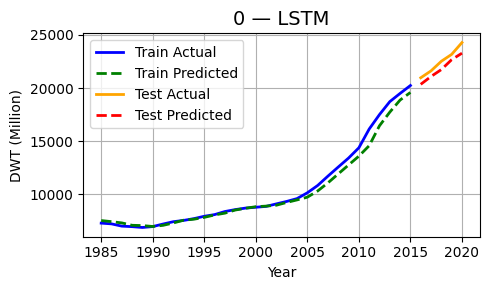

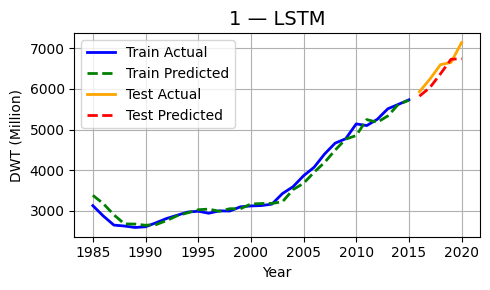

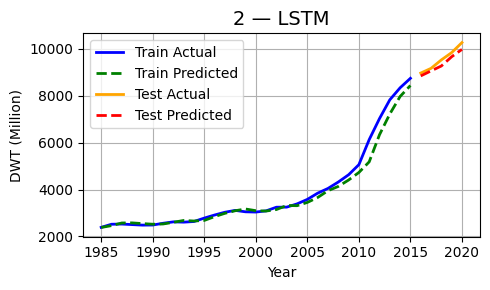

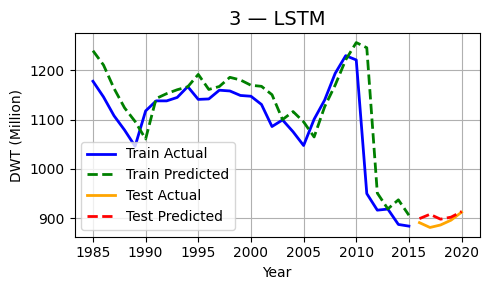

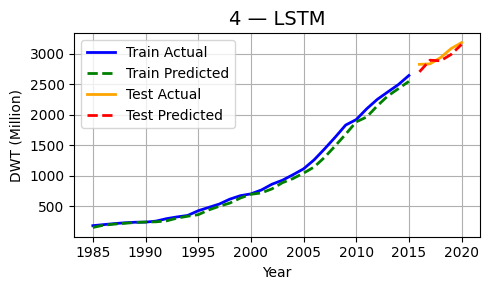

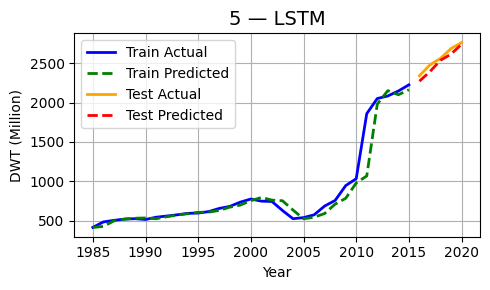

In [91]:
import matplotlib.pyplot as plt

for ship_type in sorted(pred_train_df['ShipType'].unique()):

    # ===== Train (aggregate by Year) =====
    train_g = (
        pred_train_df[pred_train_df['ShipType'] == ship_type]
        .groupby('Year', as_index=False)
        .agg({
    'DWT_true_million': 'sum',
    'DWT_pred_million': 'sum'
})

        .sort_values('Year')
    )

    # ===== Test (aggregate by Year) =====
    test_g = (
        pred_test_df[pred_test_df['ShipType'] == ship_type]
        .groupby('Year', as_index=False)
        .agg({
        'DWT_true_million': 'sum',
        'DWT_pred_million': 'sum'
    })
        .sort_values('Year')
    )

    if train_g.empty or test_g.empty:
        continue

    plt.figure(figsize=(5, 3))

    # Train
    plt.plot(
        train_g['Year'],
        train_g['DWT_true_million'],
        color='blue',
        linewidth=2,
        label='Train Actual'
    )
    plt.plot(
        train_g['Year'],
        train_g['DWT_pred_million'],
        color='green',
        linestyle='--',
        linewidth=2,
        label='Train Predicted'
    )

    # Test
    plt.plot(
        test_g['Year'],
        test_g['DWT_true_million'],
        color='orange',
        linewidth=2,
        label='Test Actual'
    )
    plt.plot(
        test_g['Year'],
        test_g['DWT_pred_million'],
        color='red',
        linestyle='--',
        linewidth=2,
        label='Test Predicted'
    )

    plt.title(f'{ship_type} — LSTM', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('DWT (Million)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

